# Анализ взаимосвязи поведения пользователей мобильной игры "Космические братья" с источником их перехода в приложение

Команда мобильной игры «Космические братья» разыскивает гуру аналитики для реализации грандиозных планов. Игра уже пользуется большой популярностью — настало время на ней зарабатывать. На данном этапе есть **основная задача: проанализировать поведение игроков в зависимости от источника перехода и попытаться выявить более эффективные источники**. В нашем случае мы определяем эффективность рекламных источников не по финансовой составляющей, а именно по поведению (активности) пользователей в приложении, поскольку на данном этапе монетизация игры только планируется, но предполагается, что в приложении будет происходить показ рекламы на экране с выбором типа объекта для постройки. Соответственно, в этой модели монетизации более активные пользователи в перспективе принесут компании больше денег. 

## Изучение данных из файла и предобработка данных

Любое аналитическое исследование начинается с обзора данных. Тем более, что заранее о качестве предоставляемых данных ничего не известно. 

Начнем нашу работу с импорта ряда библиотек-основных инструментов аналитика.

In [1]:
import pandas as pd
import numpy as np
import math as mth
import seaborn as sns
import datetime
import matplotlib.pyplot as plt
from scipy import stats as st

Читаем предоставленные нам файлы и сохраняем в соответствующие переменные. При загрузке датасетов столбцы с датой имеют тип данных `object`. Переведем столбцы с датами к нужным типам на этапе загрузки датафрейма, указав параметр `parse_dates`:

In [2]:
try:
    user_source = pd.read_csv('/datasets/user_source.csv')
    game_actions = pd.read_csv('/datasets/game_actions.csv', parse_dates=['event_datetime'])
    ad_costs = pd.read_csv('/datasets/ad_costs.csv', parse_dates=['day'])
except:
    user_source = pd.read_csv('user_source.csv')
    game_actions = pd.read_csv('game_actions.csv', parse_dates=['event_datetime'])
    ad_costs = pd.read_csv('ad_costs.csv', parse_dates=['day'])

### Датасет `game_actions`

Основной датасет `game_actions` содержит данные о событиях, совершенных в мобильной игре «Космические братья». В ней пользователи строят свою космическую программу и пытаются преуспеть в нелёгком деле колонизации галактики.

Основная монетизация игры — только планируется. Но предполагается, что в приложении будет происходить показ рекламы на экране с выбором типа объекта для постройки.

В датасете представлены данные по игре пользователей на первом уровне. Завершение первого уровня требует от игрока выполнения одного из двух условий:
- Победа над первым врагом
- Реализация проекта - разработка орбитальной сборки спутников

В датасете содержатся данные первых пользователей приложения — когорты пользователей, которые начали пользоваться приложением в период с 4 по 10 мая включительно.

Выведем на экран первые 5 строк основного датасета:

In [3]:
game_actions.head()

,event_datetime,event,building_type,user_id,project_type
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN
2,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN
3,2020-05-04 00:00:16,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c,NaN
4,2020-05-04 00:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,NaN


Получим общую информацию о таблице:

In [4]:
game_actions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135640 entries, 0 to 135639
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   event_datetime  135640 non-null  datetime64[ns]
 1   event           135640 non-null  object        
 2   building_type   127957 non-null  object        
 3   user_id         135640 non-null  object        
 4   project_type    1866 non-null    object        
dtypes: datetime64[ns](1), object(4)
memory usage: 5.2+ MB


Обратимся к документации к данным:

* `event_datetime` —  время события;
* `event` — одно из трех событий:
1. `building` — объект построен,
2. `finished_stage_1` — первый уровень завершён,
3. `project` — проект завершён;
* `building_type` — один из трёх типов здания:
1. `assembly_shop` — сборочный цех,
2. `spaceport` — космопорт,
3. `research_center` — исследовательский центр;
* `user_id` — идентификатор пользователя;
* `project_type` — тип реализованного проекта.

Из описания данных мы видим, что в нашем датасете присутствуют пропуски: относительно небольшое количество в столбце `building_type` и практически все ячейки в столбце `project_type`. Выведем на экран количество пропусков в процентах в каждом столбце:

In [5]:
round(game_actions.isna().sum() / len(game_actions) * 100, 2)

event_datetime     0.00
event              0.00
building_type      5.66
user_id            0.00
project_type      98.62
dtype: float64

Заказчик сообщил, что часть пропусков могут быть связаны с механикой сбора данных. В таком случае мы можем предположить, что такое большое количество пропусков в столбце `project_type` связано с тем, что в этом столбце заполнены только те строки, у которых в столбце `event` указано `project` (т.е. тип события: проект завершен). Проверим нашу гипотезу; сделаем срез данных (выберем только те строки, у которых в столбце в столбце `event` указано `project`) и выведем на экран количество пропусков в процентах в каждом столбце в этом срезе:

In [6]:
round(
    game_actions.query('event == "project"').isna().sum() / 
    len(game_actions.query('event == "project"')) * 100, 2
)

event_datetime      0.0
event               0.0
building_type     100.0
user_id             0.0
project_type        0.0
dtype: float64

Наша гипотеза подтвердилась, мы видим, что в рассматриваемом срезе данных в столбце `project_type` пропуски отсутствуют. Получается, такое большое количество пропусков в этом столбце связано с тем, что в нем заполнены только те строки, у которых в столбце `event` указано `project` (т.е. тип события: проект завершен). Следовательно, в данном случае нам не требуется никак дополнительно обрабатывать пропуски в столбце `project_type`.

При этом 100% пропусков в столбце `building_type` в рассматриваемом нами срезе наталкивают нас на мысль, что пропуски в этом столбце также имеют взаимосвязь со столбцом `event`. Вероятно, в этом столбце заполнены только те строки, у которых в столбце `event` указано `building` (т.е. тип события: объект построен). Проведем такую же проверку через срез данных:

In [7]:
round(
    game_actions.query('event == "building"').isna().sum() / 
    len(game_actions.query('event == "building"')) * 100, 2
)

event_datetime      0.0
event               0.0
building_type       0.0
user_id             0.0
project_type      100.0
dtype: float64

Наша гипотеза вновь подтвердилась. Получается, пропуски в этом столбце также не нуждаются в дополнительной обработке.

Теперь более подробно изучим значения в каждом столбце; проверим, соответствуют ли данные в датасете документации. Выведем на экран уникальные значения, которые хранятся в столбцах `event`, `building_type` и `project_type`:

In [8]:
print(game_actions['event'].unique())
print(game_actions['building_type'].unique())
print(game_actions['project_type'].unique())

['building' 'finished_stage_1' 'project']
['assembly_shop' 'spaceport' nan 'research_center']
[nan 'satellite_orbital_assembly']


Мы видим, что данные в столбцах `event` и `building_type` полностью соответствуют документации, а в столбце `project_type` встречается только один тип проекта `satellite_orbital_assembly`, как и сказано в описании датасета.

Теперь изучим хронологические рамки нашего датасета. Выведем на экран минимальное и максимальное значение даты из датафрейма:

In [9]:
game_actions['event_datetime'].min(), game_actions['event_datetime'].max()

(Timestamp('2020-05-04 00:00:01'), Timestamp('2020-06-05 12:32:49'))

Мы видим, что в нашем датасете хранится информация о действиях пользователей с 4 мая до середины дня 5 июня. Таким способом проверить информацию из документации о поступлении новых пользователей в приложение с 4 по 10 мая у нас не получится. Тогда сделаем это другим способом — создадим сводную таблицу, сгруппировав данные по id пользователям и получим для каждого пользователя время первого события в игре (это и будем считать началом игры). По полученной сводной таблице построим столбчатую диаграмму, чтобы наглядно увидеть, когда и сколько новых пользователей приходило в приложение. Для удобства визуализации извлечем из времени первого события в игре только день:

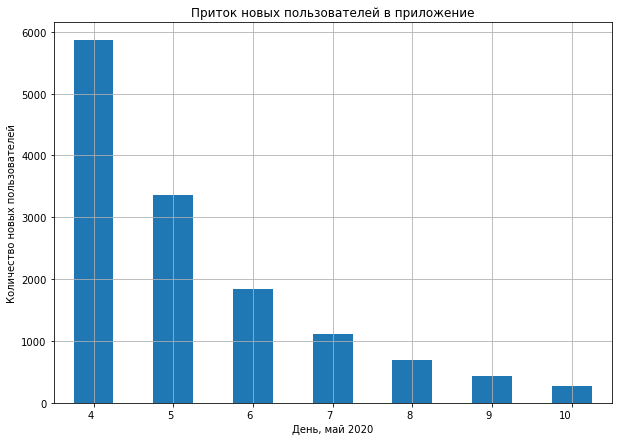

In [10]:
data = game_actions.copy()
data['day'] = data['event_datetime'].dt.day
data['month'] = data['event_datetime'].dt.month
data = data.query('month == 5').copy()
data = data.groupby('user_id', as_index=False).agg({'day':'min'})
data = data.groupby('day', as_index=False).agg({'user_id': 'count'})

fig = plt.figure(figsize =(10, 7))
ax = data['user_id'].plot(kind="bar")

plt.title("Приток новых пользователей в приложение")
plt.xlabel("День, май 2020")
plt.ylabel("Количество новых пользователей")
ax.set_xticklabels(data['day'])
plt.xticks(rotation=0, ha='right')
plt.grid()

plt.show() 

Мы видим, что действительно новые пользователи приходили в приложение с 4 по 10 мая, при этом с каждым последующим днем новых пользователей становилось все меньше.

Также стоит отметить, что все типы данных в столбцах соответствуют хранящимся в них значениям и не нуждаются в корректировке.

Теперь проведем проверку на наличие дубликатов:

In [11]:
game_actions.duplicated().sum()

1

Всего 1 дубликат! Удаляем его из нашего датафрейма:

In [12]:
game_actions = game_actions.drop_duplicates().reset_index(drop=True)

Помимо основного датасета есть два датасета с информацией о рекламных активностях.

### Датасет `user_source`

Перейдем к обработке данных в датафрейме `user_source`. Для начала выведем на экран первые 5 строк этого датасета:

In [13]:
user_source.head()

,user_id,source
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,facebook_ads
1,00151b4f-ba38-44a8-a650-d7cf130a0105,yandex_direct
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,youtube_channel_reklama
3,001d39dc-366c-4021-9604-6a3b9ff01e25,instagram_new_adverts
4,002f508f-67b6-479f-814b-b05f00d4e995,facebook_ads


Получим общую информацию о таблице:

In [14]:
user_source.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13576 entries, 0 to 13575
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  13576 non-null  object
 1   source   13576 non-null  object
dtypes: object(2)
memory usage: 212.2+ KB


Обратимся к документации к данным:

* `user_id` —  идентификатор пользователя;
* `source` — источник, с которого пришел пользователь, установивший приложение.

Из описания данных мы видим, что в этом датасете отсутствуют пропуски, а все типы данных в столбцах соответствуют хранящимся в них значениям и не нуждаются в корректировке.

Проведем проверку столбца `user_id`: проверим, совпадают ли идентификаторы пользователей в этом датасете с основным; выведем на экран те id, которые встречаются только в одном из двух датафреймов:

In [15]:
id_list = user_source['user_id']
game_actions.query('user_id not in @id_list')

,event_datetime,event,building_type,user_id,project_type


In [16]:
id_list = game_actions['user_id']
user_source.query('user_id not in @id_list')

,user_id,source


Все корректно, такие id отсутствуют. 

Проведем проверку на наличие скрытых дубликатов в столбце `source`; выведем на экран уникальные значения из этого столбца:

In [17]:
user_source['source'].unique()

array(['facebook_ads', 'yandex_direct', 'youtube_channel_reklama',
       'instagram_new_adverts'], dtype=object)

Все корректно, скрытые дубликаты отсутствуют. 

Проводим проверку на наличие полных дубликатов:

In [18]:
user_source.duplicated().sum()

0

Дубликаты отсутствуют.

### Датасет `ad_costs`

Перейдем к обработке данных в датафрейме `ad_costs`. Для начала выведем на экран первые 5 строк этого датасета:

In [19]:
ad_costs.head()

,source,day,cost
0,facebook_ads,2020-05-03,935.882786
1,facebook_ads,2020-05-04,548.354480
2,facebook_ads,2020-05-05,260.185754
3,facebook_ads,2020-05-06,177.982200
4,facebook_ads,2020-05-07,111.766796


Получим общую информацию о таблице:

In [20]:
ad_costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   source  28 non-null     object        
 1   day     28 non-null     datetime64[ns]
 2   cost    28 non-null     float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 800.0+ bytes


Обратимся к документации к данным:

* `source` —  название события;
* `day` — день, в который был совершен клик по объявлению;  
* `cost` — стоимость кликов.

Из описания данных мы видим, что в этом датасете отсутствуют пропуски, а все типы данных в столбцах соответствуют хранящимся в них значениям и не нуждаются в корректировке.

Проведем проверку столбца `source`: проверим, совпадает ли список источников в этом датасете с датасетом `user_source`; выведем на экран те источники, которые встречаются только в одном из двух датафреймов:

In [21]:
source_list = user_source['source']
ad_costs.query('source not in @source_list')

,source,day,cost


In [22]:
source_list = ad_costs['source']
user_source.query('source not in @source_list')

,user_id,source


Все корректно, такие источники отсутствуют. 

Теперь изучим хронологические рамки наших данных; выведем на экран минимальное и максимальное значение даты из датафрейма:

In [23]:
ad_costs['day'].min(), ad_costs['day'].max()

(Timestamp('2020-05-03 00:00:00'), Timestamp('2020-05-09 00:00:00'))

В нашем распоряжении данные о рекламной активности с 3 по 9 мая включительно, как и было заявлено в документации. 

Проведем проверку данных по рекламной активности: сопоставим распределение рекламных расходов по дням с притоком новых пользователей в приложение и проверим, нет ли аномалий, соотносятся ли рекламные расходы с количеством новых пользователей.

Для этого с помощью столбчатой диаграммы визуализируем распределение рекламных расходов по дням:

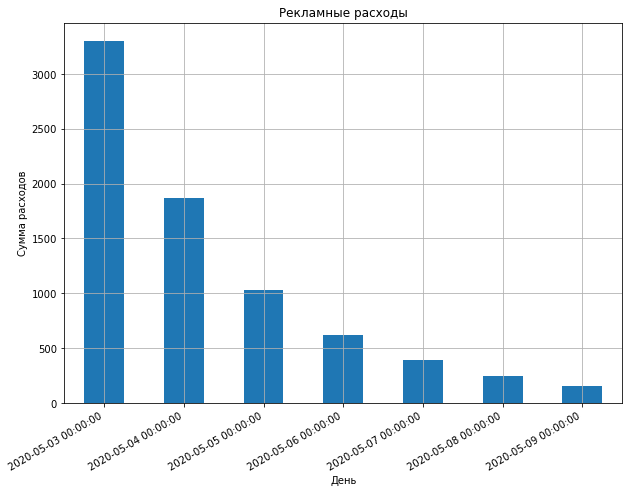

In [24]:
data = ad_costs.groupby('day', as_index=False).agg({'cost':'sum'})
data['cost'] = round(data['cost'], 2)

fig = plt.figure(figsize =(10, 7))
ax = data['cost'].plot(kind="bar")

plt.title("Рекламные расходы")
plt.xlabel("День")
plt.ylabel("Сумма расходов")
ax.set_xticklabels(data['day'])
plt.xticks(rotation=30, ha='right')
plt.grid()

plt.show() 

Мы видим, что график распределения рекламных расходов очень похож на график притока новых пользователей в приложение, только наблюдается сдвиг в один день (новые пользователи попадали в приложение с 4 по 10 мая). Аномалий не наблюдается и мы можем назвать полученные данные по рекламной активности корректными.

Теперь проведем проверку на наличие дубликатов:

In [25]:
ad_costs.duplicated().sum()

0

Дубликаты отсутствуют.

### Вывод

Полученные для анализа данные были собраны аккуратно: в них не были обнаружены какие-либо аномалии, практически отсутствуют дубликаты, а обнаруженные пропуски связаны с особенностями сбора данных.

## Исследовательский анализ данных

Основная задача, которую мы ставим перед собой на этапе исследовательского анализа данных — изучить поведение пользователей в приложении и составить портрет среднестастического пользователя. 

### Какая доля пользователей завершила прохождение 1 уровня?

Прежде чем отвечать на этот вопрос, ответим для себя на другой: информацию о каком количестве уникальных пользователей хранят наши датасеты? Выведем это число на экран:

In [26]:
len(game_actions['user_id'].unique())

13576

13576 уникальных пользователей! Довольно обширная выборка. Теперь ответим на вопрос, какая доля от этих пользователей перешла на 2 уровень? С помощью среза данных получим список уникальных id только тех пользователей, которые участвовали в событии `finished_stage_1`: первый уровень завершен. Длина этого списка и будет являться числом пользователей, которые прошли 1 уровень. Остальных пользователей легко вычислить обычным вычитанием:

In [27]:
finished_1lvl_ids = game_actions.query('event == "finished_stage_1"')['user_id'].unique()
abandoned_ids = game_actions.query('user_id not in @finished_1lvl_ids')['user_id'].unique()

len(finished_1lvl_ids), len(abandoned_ids)

(5817, 7759)

Сразу визуализируем полученные результаты и построим pie chart:

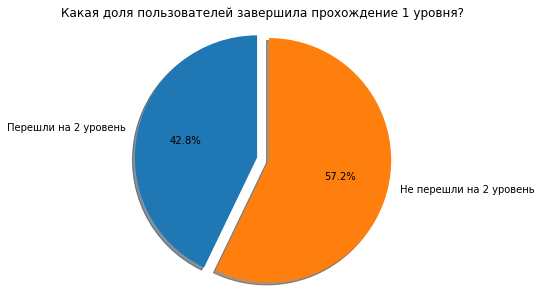

In [28]:
labels = 'Перешли на 2 уровень', 'Не перешли на 2 уровень'
sizes = [len(finished_1lvl_ids), len(abandoned_ids)]
explode = (0.1, 0) 

fig1, ax1 = plt.subplots(figsize=(7,5))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  
plt.title("Какая доля пользователей завершила прохождение 1 уровня?")

plt.show()

Примерно 43 процента пользователей перешли на 2 уровень. В целом, это хороший показатель вовлеченности новых пользователей для игровой индустрии, но нам он требуется в большей степени для будущего сравнения с показателями вовлеченности игроков из разных рекламных источников. Тем более нам пока сложно делать какие-либо выводы, ведь мы даже не знаем, сколько времени занимало у игроков прохождение этого самого 1 уровня.

### Сколько времени требуется пользователям, чтобы пройти 1 уровень?

Для ответа на этот вопрос нам потребуется построить сводную таблицу: сгруппируем датасет по id пользователей. Затем для каждого id получим время самого первого события в игре: будем считать его временем начала прохождения уровня. Затем вновь вернемся к изначальному датасету, сделаем срез данных по наличию события `finished_stage_1`: ведь нас интересуют только пользователи, которые прошли 1 уровень и получим время этого события для каждого пользователи. Соединим обе таблицы в одну по id пользователей. Выведем на экран первые 5 строк получившейся сводной таблицы:

In [29]:
passing_speed = (
    game_actions
    .groupby('user_id', as_index=False)
    .agg({'event_datetime': 'min'})
    .rename(columns={'event_datetime':'start_datetime'}).merge(
        game_actions.query('event == "finished_stage_1"')
        .groupby('user_id', as_index=False)
        .agg({'event_datetime':'first'}), how='inner', on='user_id'
    ).rename(columns={'event_datetime':'finish_datetime'})
)

passing_speed.head()

,user_id,start_datetime,finish_datetime
0,001d39dc-366c-4021-9604-6a3b9ff01e25,2020-05-05 21:02:05,2020-05-12 07:40:47
1,003ee7e8-6356-4286-a715-62f22a18d2a1,2020-05-05 08:31:04,2020-05-17 21:47:49
2,004074f8-251a-4776-922c-8348dca1a2f6,2020-05-04 01:07:35,2020-05-16 19:57:40
3,00464e5e-28ed-4be6-bf44-517ef7b3937b,2020-05-04 08:35:29,2020-05-15 16:02:01
4,0056c007-c082-43cc-bdef-afc49bca4cb9,2020-05-10 11:49:47,2020-05-16 13:48:39


Теперь у нас есть вся информация для подсчета времени, которое игроки потратили на прохождение первого уровня: нам достаточно вычесть значение первого события из значения последнего события. Но полученный результат будет храниться в том же формате, что и исходные столбцы: с часами, минутами и секундами. С данными в таком формате будет неудобно работать впоследствии, эта информация о времени будет излишней и помешает нам визуализировать данные. Поэтому из полученной информации о времени прохождения уровня сохраним лишь количество полных дней:

In [30]:
passing_speed['time_difference_days'] = (
    passing_speed['finish_datetime'] - passing_speed['start_datetime']
).dt.days

passing_speed.head()

,user_id,start_datetime,finish_datetime,time_difference_days
0,001d39dc-366c-4021-9604-6a3b9ff01e25,2020-05-05 21:02:05,2020-05-12 07:40:47,6
1,003ee7e8-6356-4286-a715-62f22a18d2a1,2020-05-05 08:31:04,2020-05-17 21:47:49,12
2,004074f8-251a-4776-922c-8348dca1a2f6,2020-05-04 01:07:35,2020-05-16 19:57:40,12
3,00464e5e-28ed-4be6-bf44-517ef7b3937b,2020-05-04 08:35:29,2020-05-15 16:02:01,11
4,0056c007-c082-43cc-bdef-afc49bca4cb9,2020-05-10 11:49:47,2020-05-16 13:48:39,6


Выведем на экран краткое статистическое описание по времени прохождения:

In [31]:
passing_speed['time_difference_days'].describe()

count    5817.000000
mean       11.362214
std         4.080387
min         0.000000
25%         9.000000
50%        11.000000
75%        14.000000
max        30.000000
Name: time_difference_days, dtype: float64

Некоторые значения из списка намекают на присутствие выбросов в наших данных: это минимальное значение, равное нулю, и максимальное значение, которое слишком сильно отдаляется от значения 3 квартиля. Для проверки на наличие выбросов построим график boxplot: 

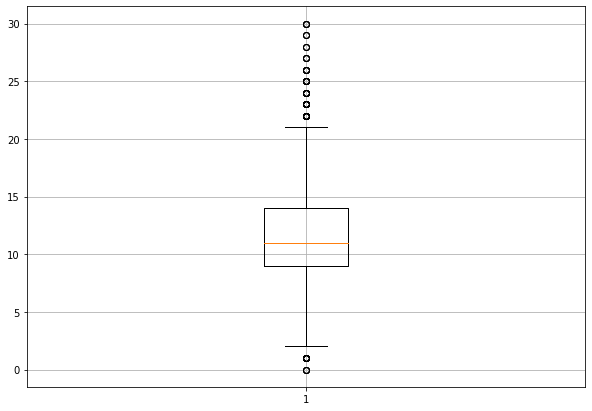

In [32]:
fig = plt.figure(figsize =(10, 7))
plt.boxplot(passing_speed['time_difference_days'])
plt.grid()
plt.show()

Несмотря на наличие значений за пределами "усов" нашего графика, эти значения нельзя назвать аномальными: они не имеют большого отдаления от самого графика и в целом при обычном прикладном анализе они выглядят реалистичными: мы можем допустить, что один или несколько игроков могли потратить на прохождение 1 уровня как целый месяц, так и 0 целых дней (то есть менее 24 часов). Да, такие случаи единичны, но если такие уникальные пользователи были привлечены лишь по одному источнику, нам это важно знать и понимать, поэтому при дальнейшем анализе важно учесть всех пользователей.

Теперь построим столбчатую диаграмму, чтобы визуализировать данные:

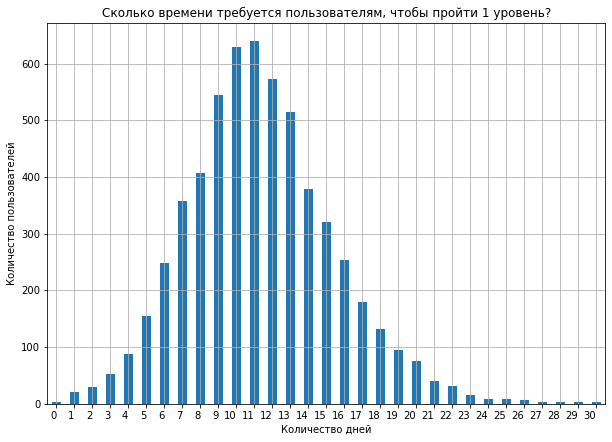

In [33]:
data = (
    passing_speed
    .groupby('time_difference_days', as_index=False)
    .agg({'user_id':'count'})
    .sort_values('time_difference_days')
)

fig = plt.figure(figsize =(10, 7))
ax = data['user_id'].plot(kind="bar")

plt.title("Сколько времени требуется пользователям, чтобы пройти 1 уровень?")
plt.xlabel("Количество дней")
plt.ylabel("Количество пользователей")
ax.set_xticklabels(data['time_difference_days'])
plt.xticks(rotation=0, ha='right')
plt.grid()

plt.show() 

Полученный график напоминает нам график нормального распределения с удлиненным "хвостом".

Получается, в среднем, пользователи тратят на прохождение 1 уровня примерно 11 дней. Если говорить более подробно, то можно сказать, что половина всех пользователей тратит на прохождение 1 уровня от 9 до 14 дней. Чем больше отклонение от этих значений, тем меньшее количество пользователей мы можем описать этим значением. Если мы вспомним тот факт, что новые пользователи приходили в приложение с 4 по 10 мая, а датасет хранит информацию об их действиях в игре вплоть до 5 июня, это означает, что в распоряжении практически всех новых пользователей (за исключением тех редких случаев случаев, когда игрокам требовалось на прохождение около 1 месяца) было достаточно времени, чтобы пройти 1 уровень.

### Какое в среднем количество построек строят пользователи?

Только что мы изучили вопрос, сколько времени тратят пользователи на прохождение 1 уровня. Но в таком случае без внимания остались пользователи, которые не закончили 1 уровень, как оценить их вовлеченность в игру? Нам кажется, что отдельно уделять вниманию вопросу длительности вовлечения в игру пользователей, которые не прошли 1 уровень не стоит. В начале нашего исследования, мы обращали внимание, что предполагаемая модель монетизации строится на том, что в приложении будет происходить показ рекламы на экране с выбором типа объекта для постройки. Следовательно, если пользователь покинул приложение на этапе 1 уровня, нам важнее оценить не как быстро он это сделал, а насколько он вовлекся в сам процесс игры, как много построек он успел построить. 

И при ответе на вопрос, вынесенном в подзаголовок, мы будем учитывать данные уже обо всех пользователях, в том числе и о тех, кто не прошел до конца 1 уровень. 

Для ответа на этот вопрос сначала построим сводную таблицу: сгруппируем данные по id пользователей, и подсчитаем для каждого пользователя количество событий `building`:

In [34]:
buildings_count = (
    game_actions.query('event == "building"')
    .groupby('user_id', as_index=False)
    .agg({'building_type': 'count'})
    .rename(columns={'building_type': 'buildings_cnt'})
)

buildings_count.head()

,user_id,buildings_cnt
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,13
1,00151b4f-ba38-44a8-a650-d7cf130a0105,9
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,4
3,001d39dc-366c-4021-9604-6a3b9ff01e25,8
4,002f508f-67b6-479f-814b-b05f00d4e995,12


Выведем на экран краткое статистическое описание по количеству построек:

In [35]:
buildings_count['buildings_cnt'].describe()

count    13576.000000
mean         9.425162
std          3.860800
min          1.000000
25%          6.000000
50%         10.000000
75%         12.000000
max         20.000000
Name: buildings_cnt, dtype: float64

С помощью графика boxplot проверим наши данные на наличие статистических выбросов:

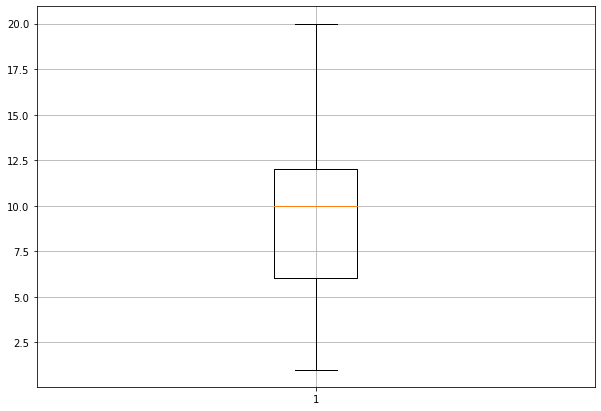

In [36]:
fig = plt.figure(figsize =(10, 7))
plt.boxplot(buildings_count['buildings_cnt'])
plt.grid()
plt.show()

Выбросы отсутствуют. Теперь построим столбчатую диаграмму, чтобы визуализировать данные:

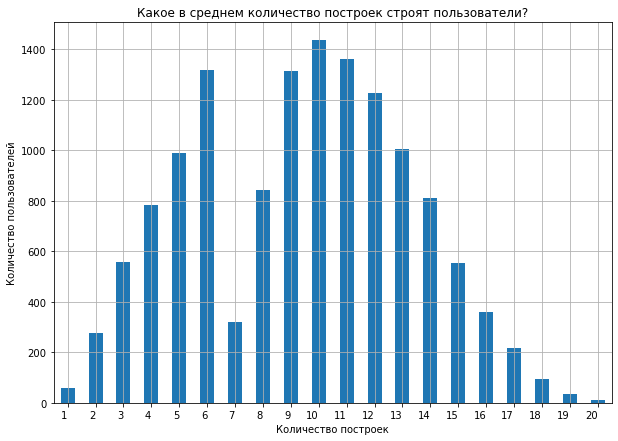

In [37]:
data = (
    buildings_count
    .groupby('buildings_cnt', as_index=False)
    .agg({'user_id':'count'})
    .sort_values('buildings_cnt')
)

fig = plt.figure(figsize =(10, 7))
ax = data['user_id'].plot(kind="bar")

plt.title("Какое в среднем количество построек строят пользователи?")
plt.xlabel("Количество построек")
plt.ylabel("Количество пользователей")
ax.set_xticklabels(data['buildings_cnt'])
plt.xticks(rotation=0, ha='right')
plt.grid()

plt.show() 

Получается, в среднем пользователи строили около 9-10 построек. График за некоторыми исключениями (речь идет о "просадке" на 7-8 объектах) напоминает график нормального распределения, но возможно, его искажает смешение данных: мы рассматривали вместе и тех пользователей, кто прошел 1 уровень, и тех, кто покинул приложение раньше. Рассмотрим теперь этих пользователей по отдельности. Сначала изучим данные по пользователям, которые завершили прохождение 1 уровня:

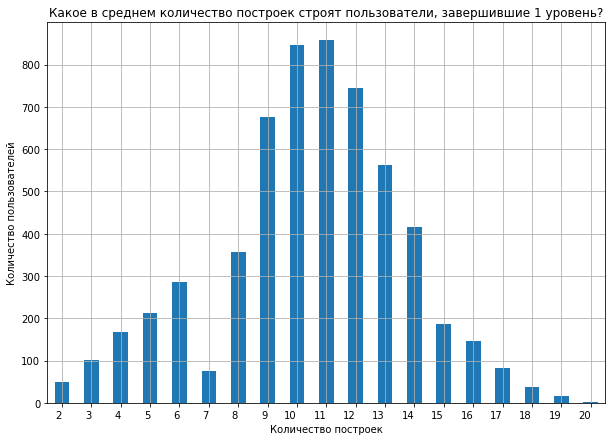

In [38]:
buildings_count = (
    game_actions.query('event == "building" and user_id in @finished_1lvl_ids')
    .groupby('user_id', as_index=False)
    .agg({'building_type': 'count'})
    .rename(columns={'building_type': 'buildings_cnt'})
)

data = (
    buildings_count
    .groupby('buildings_cnt', as_index=False)
    .agg({'user_id':'count'})
    .sort_values('buildings_cnt')
)

fig = plt.figure(figsize =(10, 7))
ax = data['user_id'].plot(kind="bar")

plt.title("Какое в среднем количество построек строят пользователи, завершившие 1 уровень?")
plt.xlabel("Количество построек")
plt.ylabel("Количество пользователей")
ax.set_xticklabels(data['buildings_cnt'])
plt.xticks(rotation=0, ha='right')
plt.grid()

plt.show() 

Выведем на экран краткое статистическое описание данных:

In [39]:
buildings_count['buildings_cnt'].describe()

count    5817.000000
mean       10.449716
std         3.184264
min         2.000000
25%         9.000000
50%        11.000000
75%        12.000000
max        20.000000
Name: buildings_cnt, dtype: float64

Мы видим, что среднее и медиана относительно смешанных данных стали немного больше, что и логично: пользователи, которые завершили 1 уровень, в среднем строили около 10-11 построек. Интересно, что и на этом графике наблюдается просадка значений на отметке в 7 построек.

Теперь рассмотрим данные по пользователям, которые покинули игру до завершения 1 уровня:

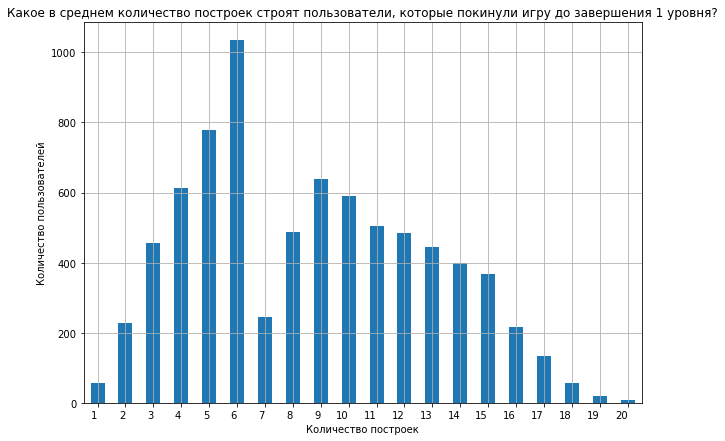

In [40]:
buildings_count = (
    game_actions.query('event == "building" and user_id in @abandoned_ids')
    .groupby('user_id', as_index=False)
    .agg({'building_type': 'count'})
    .rename(columns={'building_type': 'buildings_cnt'})
)

data = (
    buildings_count
    .groupby('buildings_cnt', as_index=False)
    .agg({'user_id':'count'})
    .sort_values('buildings_cnt')
)

fig = plt.figure(figsize =(10, 7))
ax = data['user_id'].plot(kind="bar")

plt.title("Какое в среднем количество построек строят пользователи, которые покинули игру до завершения 1 уровня?")
plt.xlabel("Количество построек")
plt.ylabel("Количество пользователей")
ax.set_xticklabels(data['buildings_cnt'])
plt.xticks(rotation=0, ha='right')
plt.grid()

plt.show() 

Выведем на экран краткое статистическое описание данных:

In [41]:
buildings_count['buildings_cnt'].describe()

count    7759.000000
mean        8.657043
std         4.135660
min         1.000000
25%         5.000000
50%         8.000000
75%        12.000000
max        20.000000
Name: buildings_cnt, dtype: float64

Относительно общих показателей мы отмечаем уменьшение среднего и медианы: в среднем, пользователи, которые не завершили прохождение 1 уровня, строили примерно по 8 построек. 

Кроме того, стоит отметить, что "просадка" на 7-8 объектах оказалась характерна для всех пользователей. Возможно, она вызвана какими-то особенностями механики игры, которые мешают игрокам развиваться равномерно. Поэтому нам стоит передать эту информацию отделу геймдева, чтобы они выяснили в чём дело, и, при необходимости, исправили.

### Какую стратегию обычно выбирают пользователи для прохождения 1 уровня?

Механика игры построена так, что завершить первый уровень можно, выполнив одно из двух условий:
- Победа над первым врагом (победа в режиме PvP)
- Реализация проекта — разработка орбитальной сборки спутников (победа в режиме PvE)

В датасете нет специальной отметки о победе в режиме PvP, мы можем вычислить таких игроков только методом исключения: они завершили 1 уровень без реализации проекта.

Изучим этот вопрос подробнее и ответим на вопрос, какую стратегию предпочитают пользователи для прохождения 1 уровня. Для начала создадим список уникальных id игроков, которые одержали победу в каждом из режимов:

In [42]:
pve_ids = game_actions.query('event == "project"')['user_id'].unique()

pvp_ids = (
    game_actions
    .query('event == "finished_stage_1" and user_id not in @pve_ids')['user_id']
    .unique()
)

С помощью этих список построим pie chart:

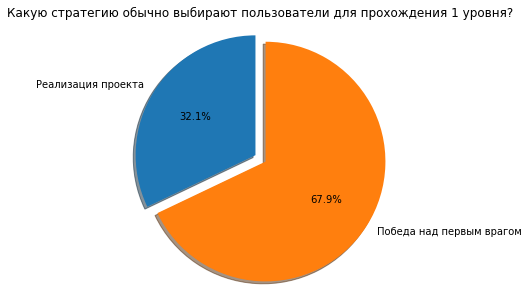

In [43]:
labels = 'Реализация проекта', 'Победа над первым врагом'
sizes = [len(pve_ids), len(pvp_ids)]
explode = (0.1, 0) 

fig1, ax1 = plt.subplots(figsize=(7,5))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  
plt.title("Какую стратегию обычно выбирают пользователи для прохождения 1 уровня?")

plt.show()

Мы видим, что чаще пользователи предпочитают PvP-стратегию для прохождения 1 уровня.

### Сколько в среднем было потрачено на привлечение 1 пользователя по каждому источнику?

Теперь проанализируем вопрос, связанный с каналами привлечения пользователей и который необходимо нам изучить для последующего ответа на вопрос заказчика: как распределяются траты компании на привлечение пользователей, сколько в среднем было потрачено на привлечение 1 пользователя по каждому источнику? Для ответа на этот вопрос воспользуемся вспомогательными датасетами `user_source` и `ad_costs`. 

Сначала создадим сводную таблицу на основе датасета `user_source`: сгруппируем его по каналам привлечения и для каждого канала подсчитаем количество привлеченных пользователей.
Затем создадим вторую сводную таблицу на основе датасета `ad_costs`: тоже сгруппируем данные по каналам привлечения и для каждого канала подсчитаем сумму рекламных расходов.
Объединим эти таблицы в единую сводную, в которой добавим новый столбец: разделим сумму расходов по каждому каналу на количество привлеченных пользователей.

Выведем результат на экран:

In [44]:
costs_per_user = (user_source
                 .groupby('source', as_index=False)
                 .agg({'user_id': 'count'})
                 .rename(columns={'user_id':'user_cnt'})
                 .merge(ad_costs
                        .groupby('source', as_index=False)
                        .agg({'cost': 'sum'})
                        .rename(columns={'cost':'sum'}), how='inner', on='source')
)

costs_per_user['sum'] = round(costs_per_user['sum'], 2)
costs_per_user['per_user'] = round(costs_per_user['sum'] / costs_per_user['user_cnt'], 2)

costs_per_user.sort_values('per_user')

,source,user_cnt,sum,per_user
3,youtube_channel_reklama,2686,1068.12,0.40
2,yandex_direct,4817,2233.11,0.46
1,instagram_new_adverts,3347,2161.44,0.65
0,facebook_ads,2726,2140.90,0.79


Мы видим, что с финансовой точки зрения самым выгодным каналом для привлечения новых пользователей был YouTube, самым невыгодным — Facebook; средняя стоимость привлечения 1 пользователя по этим каналам отличается практически в 2 раза!

Визуализируем полученный результат с помощью столбчатой диаграммы:

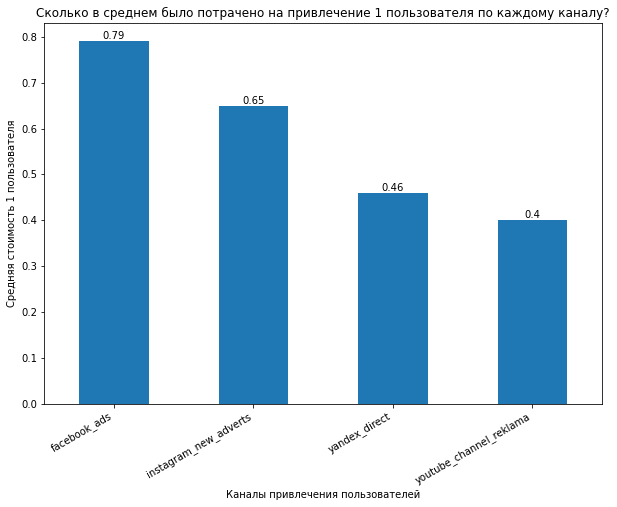

In [45]:
fig = plt.figure(figsize =(10, 7))
ax = costs_per_user['per_user'].plot(kind="bar")

plt.title("Сколько в среднем было потрачено на привлечение 1 пользователя по каждому каналу?")
plt.xlabel("Каналы привлечения пользователей")
plt.ylabel("Средняя стоимость 1 пользователя")
ax.set_xticklabels(costs_per_user['source'])
plt.xticks(rotation=30, ha='right')

rects = ax.patches

labels = [i for i in list(costs_per_user['per_user'])]


for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2, height, label, ha="center", va="bottom"
    )

plt.show() 

### Вывод

Исследовательский анализ данных показал, что до конца проходят 1 уровень менее половины пользователей: примерно 43 процента. В целом, это хороший показатель вовлеченности новых пользователей для игровой индустрии. При этом в среднем пользователи тратили на прохождение 1 уровня примерно 11 дней. Если говорить более подробно, то можно сказать, что половина всех пользователей тратит на прохождение 1 уровня от 9 до 14 дней. Для прохождения 1 уровня пользователи часто предпочитали PvP-стратегию (победа над первым игроком): такой выбор сделали практически 68% пользователей.

Что касается количества построенных за время прохождения уровня объектов, то в среднем все пользователи приложения строили около 9-10 построек, при этом пользователи, которые прошли 1 уровень до конца, в среднем строили немного больше построек (около 10-11), чем пользователи, которые не завершили прохождение 1 уровня (примерно 8), что крайне логично.

Что касается рекламных источников, то с финансовой точки зрения самым выгодным каналом для привлечения новых пользователей был YouTube, самым невыгодным — Facebook; средняя стоимость привлечения 1 пользователя по этим каналам отличается практически в 2 раза! (0.4 и 0.79)

## Анализ влияния источника перехода в игру на поведение пользователей

Теперь перейдем непосредственно к ответу на вопрос для нашего заказчика — отличается ли поведение пользователей в приложении в зависимости от канала привлечения, можно ли выявить более эффективные источники привлечения пользователей? 

Для ответа на этот вопрос мы вновь изучим поведение пользователей в приложении, но теперь разобьем их на когорты по каналу привлечения. Для того, чтобы разбить пользователей на когорты, мы создадим новый датафрейм на основе `game_actions`, куда добавим столбец с информацией о канале привлечения пользователя. Этот столбец впоследствии мы будем использовать для срезов данных по источнику:

In [46]:
game_actions_upd = (
    game_actions
    .merge(user_source, how='inner', on='user_id')
)

game_actions_upd.head()

,event_datetime,event,building_type,user_id,project_type,source
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,youtube_channel_reklama
1,2020-05-05 05:20:15,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,youtube_channel_reklama
2,2020-05-05 19:24:02,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,youtube_channel_reklama
3,2020-05-05 20:59:19,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,youtube_channel_reklama
4,2020-05-06 00:52:56,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,youtube_channel_reklama


Теперь изучим вопрос влияния источника перехода в игру на вовлеченность пользователей; ответим на вопрос, какая доля пользователей завершила прохождение 1 уровня для каждого источника. Для наглядности как и в части исследовательского анализа вновь построим графики pie chart, но разместим их все вместе с помощью функции `plt.subplots`:

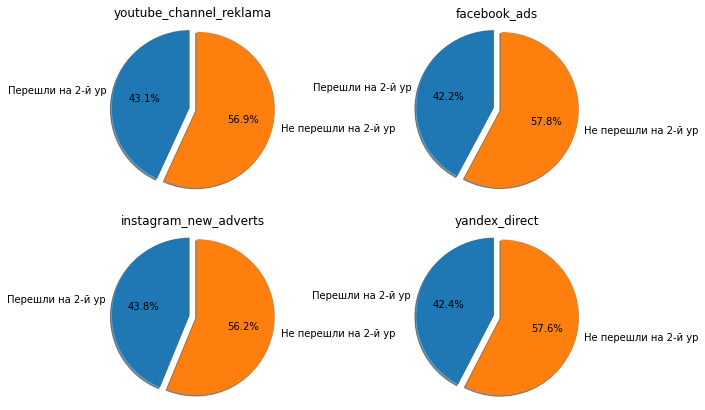

In [47]:
labels = 'Перешли на 2-й ур', 'Не перешли на 2-й ур'
explode = (0.1, 0) 

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,7))

sizes = [len(game_actions_upd.query('user_id in @finished_1lvl_ids and source == "youtube_channel_reklama"')['user_id'].unique()),
         len(game_actions_upd.query('user_id in @abandoned_ids and source == "youtube_channel_reklama"')['user_id'].unique())
        ]
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  
ax1.set_title('youtube_channel_reklama')

sizes = [len(game_actions_upd.query('user_id in @finished_1lvl_ids and source == "facebook_ads"')['user_id'].unique()),
         len(game_actions_upd.query('user_id in @abandoned_ids and source == "facebook_ads"')['user_id'].unique())
        ]
ax2.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax2.axis('equal')  
ax2.set_title('facebook_ads')

sizes = [len(game_actions_upd.query('user_id in @finished_1lvl_ids and source == "instagram_new_adverts"')['user_id'].unique()),
         len(game_actions_upd.query('user_id in @abandoned_ids and source == "instagram_new_adverts"')['user_id'].unique())
        ]
ax3.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax3.axis('equal')  
ax3.set_title('instagram_new_adverts')

sizes = [len(game_actions_upd.query('user_id in @finished_1lvl_ids and source == "yandex_direct"')['user_id'].unique()),
         len(game_actions_upd.query('user_id in @abandoned_ids and source == "yandex_direct"')['user_id'].unique())
        ]
ax4.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax4.axis('equal')  
ax4.set_title('yandex_direct')

plt.show()

Мы видим, что в среднем пользователи, привлеченные из YouTube и Instagram, активнее вовлекались в игру и чаще переходили на 2 уровень, чем пользователи из Facebook и Yandex. 

Теперь изучим вопрос, сколько времени требовалось пользователям из разных источников, чтобы закончить 1 уровень. Для ответа на этот вопрос будем использовать код из части по исследовательскому анализу данных, который мы разместим внутри цикла. Задача цикла: вывести на экран краткое статистическое описание данных по скорости прохождения 1 уровня для каждого канала привлечения пользователей:

In [48]:
for source in list(game_actions_upd['source'].unique()):
    passing_speed = (
        game_actions_upd
        .query('source == @source')
        .groupby('user_id', as_index=False)
        .agg({'event_datetime': 'min'})
        .rename(columns={'event_datetime':'start_datetime'}).merge(
            game_actions_upd.query('event == "finished_stage_1" and source == @source')
            .groupby('user_id', as_index=False)
            .agg({'event_datetime':'first'}), how='inner', on='user_id'
        ).rename(columns={'event_datetime':'finish_datetime'})
    )
    passing_speed['time_difference_days'] = (
    passing_speed['finish_datetime'] - passing_speed['start_datetime']
    ).dt.days
    
    print(source)
    print(passing_speed['time_difference_days'].describe())
    print()

youtube_channel_reklama
count    1159.000000
mean       11.402934
std         4.045171
min         0.000000
25%         9.000000
50%        11.000000
75%        14.000000
max        27.000000
Name: time_difference_days, dtype: float64

facebook_ads
count    1150.000000
mean       11.348696
std         4.063591
min         1.000000
25%         9.000000
50%        11.000000
75%        14.000000
max        30.000000
Name: time_difference_days, dtype: float64

instagram_new_adverts
count    1466.000000
mean       11.407231
std         4.038542
min         0.000000
25%         9.000000
50%        11.000000
75%        14.000000
max        30.000000
Name: time_difference_days, dtype: float64

yandex_direct
count    2042.000000
mean       11.314398
std         4.141552
min         0.000000
25%         9.000000
50%        11.000000
75%        14.000000
max        30.000000
Name: time_difference_days, dtype: float64



Мы видим, что все основные статистические показатели по скорости прохождения 1 уровня практически идентичны для каждого канала, из чего мы делаем вывод, что источник перехода в игру не влияет на скорость прохождения 1 уровня.

Теперь изучим вопрос взаимосвязи источника и количества построек, которое пользователи строят в игре с помощью подобного же цикла:

In [49]:
for source in list(game_actions_upd['source'].unique()):
    buildings_count = (
        game_actions_upd.query('event == "building" and source == @source')
        .groupby('user_id', as_index=False)
        .agg({'building_type': 'count'})
        .rename(columns={'building_type': 'buildings_cnt'})
    )
    
    print(source)
    print(buildings_count['buildings_cnt'].describe())
    print()

youtube_channel_reklama
count    2686.000000
mean        9.299330
std         3.885385
min         1.000000
25%         6.000000
50%        10.000000
75%        12.000000
max        20.000000
Name: buildings_cnt, dtype: float64

facebook_ads
count    2726.000000
mean        9.585840
std         3.869306
min         1.000000
25%         6.000000
50%        10.000000
75%        12.000000
max        20.000000
Name: buildings_cnt, dtype: float64

instagram_new_adverts
count    3347.000000
mean        9.505527
std         3.830176
min         1.000000
25%         6.000000
50%        10.000000
75%        12.000000
max        20.000000
Name: buildings_cnt, dtype: float64

yandex_direct
count    4817.000000
mean        9.348557
std         3.860250
min         1.000000
25%         6.000000
50%        10.000000
75%        12.000000
max        20.000000
Name: buildings_cnt, dtype: float64



Мы видим, что и в этом случае все основные статистические показатели по количеству построек практически идентичны для каждого канала, из чего мы делаем вывод, что в данном случае источник перехода в игру также не влияет на этот показатель.

Теперь изучим вопрос, есть ли взаимосвязь между каналом привлечения пользователей и стратегией, которую выбирают пользователи для прохождения 1 уровня. При ответе на данный вопрос мы вновь воспользуемся графиками pie chart, размещенных на одной доске. Напомним, что PvE-стратегия — это реализация проекта пользователем, а PvP — победа над первым врагом:

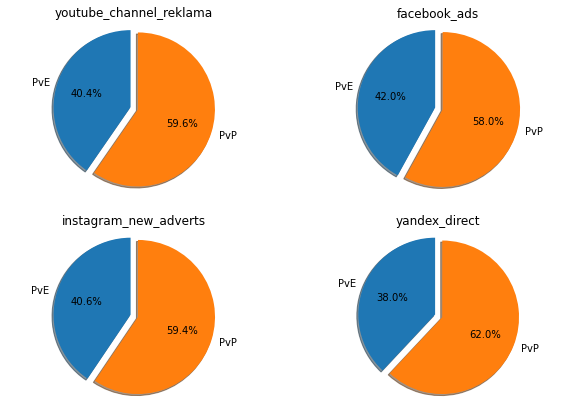

In [50]:
labels = 'PvE', 'PvP'
explode = (0.1, 0) 


fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,7))

sizes = [len(game_actions_upd.query('user_id in @pve_ids and source == "youtube_channel_reklama"')),
         len(game_actions_upd.query('user_id in @pvp_ids and source == "youtube_channel_reklama"'))
                ]
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  
ax1.set_title('youtube_channel_reklama')

sizes = [len(game_actions_upd.query('user_id in @pve_ids and source == "facebook_ads"')),
         len(game_actions_upd.query('user_id in @pvp_ids and source == "facebook_ads"'))
        ]
ax2.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax2.axis('equal')  
ax2.set_title('facebook_ads')

sizes = [len(game_actions_upd.query('user_id in @pve_ids and source == "instagram_new_adverts"')),
         len(game_actions_upd.query('user_id in @pvp_ids and source == "instagram_new_adverts"'))
        ]
ax3.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax3.axis('equal')  
ax3.set_title('instagram_new_adverts')

sizes = [len(game_actions_upd.query('user_id in @pve_ids and source == "yandex_direct"')),
         len(game_actions_upd.query('user_id in @pvp_ids and source == "yandex_direct"'))]
ax4.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax4.axis('equal')  
ax4.set_title('yandex_direct')


plt.show()

Мы видим, что заметно чаще других PvE-стратегию предпочитают пользователи, привлеченные из Facebook, а PvP-стратегию — пользователи Yandex. Пока мы не можем ответить на вопрос, какая стратегия эффективнее для компании с точки зрения монетизации, для этого в следующем разделе мы оценим взаимосвязь выбранной стратегии и поведения пользователей. 

### Вывод

Анализ влияния источника перехода в игру на поведение пользователей показал, что в среднем пользователи, привлеченные из YouTube и Instagram, активнее вовлекались в игру и чаще переходили на 2 уровень, чем пользователи из Facebook и Yandex. 

Также было выявлено, что пользователи, привлеченные из Facebook, заметно чаще других предпочитают PvE-стратегию для прохождения 1 уровня, а пользователи Yandex — PvP-стратегию.

Кроме того, мы пришли к выводу, что источник перехода в приложение никак не влияет на скорость прохождения пользователями 1 уровня и количество объектов, которые они строят в игре.

## Проверка статистических гипотез о взаимосвязи выбранной пользователями стратегии для прохождения 1 уровня и их поведения в приложении

Теперь, когда мы обнаружили взаимосвязь между каналом привлечения пользователей и тем, какую стратегию для прохождения первого уровня они выбирают, попытаемся выяснить, влияет ли выбор стратегии на поведение пользователей для того, чтобы понять, на каких пользователях приложению стоит акцентировать свое внимание при внедрении монетизации в приложении.

В этом разделе мы проверим две статистические гипотезы о влиянии выбранной пользователями стратегии на их поведение:
- время завершения уровня различается в зависимости от выбранного способа прохождения;
- количество построенных пользователем объектов различается в зависимости от выбранного способа прохождения.

### Гипотеза 1. Время завершения уровня различается в зависимости от выбранного способа прохождения

Сначала проверим наличие взаимосвязи между выбранной пользователем стратегии и скоростью прохождения. Начнем с того, что создадим два массива, каждый из которых будет содержать информацию о том, сколько дней потратили на прохождение 1 уровня пользователи, выбравшие разные стратегии. Для создания массивов воспользуемся уже знакомым кодом из части исследовательского анализа данных:

In [51]:
passing_speed_pve = (
    game_actions.query('user_id in @pve_ids')
    .groupby('user_id', as_index=False)
    .agg({'event_datetime': 'min'})
    .rename(columns={'event_datetime':'start_datetime'}).merge(
        game_actions.query('event == "finished_stage_1"')
        .groupby('user_id', as_index=False)
        .agg({'event_datetime':'first'}), how='inner', on='user_id'
    ).rename(columns={'event_datetime':'finish_datetime'})
)

passing_speed_pve['time_difference_days'] = (
    passing_speed_pve['finish_datetime'] - passing_speed_pve['start_datetime']
).dt.days

passing_speed_pve = passing_speed_pve['time_difference_days']


passing_speed_pvp = (
    game_actions.query('user_id in @pvp_ids')
    .groupby('user_id', as_index=False)
    .agg({'event_datetime': 'min'})
    .rename(columns={'event_datetime':'start_datetime'}).merge(
        game_actions.query('event == "finished_stage_1"')
        .groupby('user_id', as_index=False)
        .agg({'event_datetime':'first'}), how='inner', on='user_id'
    ).rename(columns={'event_datetime':'finish_datetime'})
)

passing_speed_pvp['time_difference_days'] = (
    passing_speed_pvp['finish_datetime'] - passing_speed_pvp['start_datetime']
).dt.days

passing_speed_pvp = passing_speed_pvp['time_difference_days']

Теперь все готово для проведения статистического теста.

Формулируем нулевую гипотезу: пользователи, которые проходят 1 уровень через реализацию проекта, тратят на завершение этого уровня столько же дней, сколько и пользователи, которые проходят 1 уровень через победу над первым игроком.

Таким образом, альтернативная гипотеза будет звучать так: пользователи, которые проходят 1 уровень через реализацию проекта и пользователи, которые проходят 1 уровень через победу над первым игроком тратят на завершение этого уровня разное количество дней.

Проводим статистический тест, выбираем в качестве критического уровня статистической значимости отметку в 5%:

In [52]:
alpha = 0.05 

results = st.ttest_ind(
    passing_speed_pve, 
    passing_speed_pvp)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Достаточно оснований, чтобы отвергнуть нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.8882835392369192e-97
Достаточно оснований, чтобы отвергнуть нулевую гипотезу


Мы видим, что p-value стремится к нулю, а это значит, что у нас достаточно оснований, чтобы отвергнуть нулевую гипотезу и принять тот факт, что пользователи, которые проходят 1 уровень через реализацию проекта и пользователи, которые проходят 1 уровень через победу над первым игроком тратят на завершение этого уровня разное количество дней. Нам осталось выяснить, кто из них тратит на прохождение уровня больше времени, а кто — меньше. Выведем на экран средние значения обеих выборок:

In [53]:
passing_speed_pve.mean(), passing_speed_pvp.mean()

(12.963022508038586, 10.606175651733738)

Получается, пользователи, которые выбрали для прохождения 1 уровня PvE-стратегию, тратят на прохождение этого уровня больше времени: в среднем, примерно на 2 дня больше.

### Гипотеза 2. Количество построенных пользователем объектов различается в зависимости от выбранного способа прохождения.

Теперь проверим наличие взаимосвязи между выбранной пользователем стратегией и количеством построенных в игре объектов. Вновь создадим два массива, каждый из которых будет содержать информацию о том, сколько объектов построили пользователи, выбравшие разные стратегии. Для создания массивов вновь воспользуемся уже знакомым кодом из части исследовательского анализа данных:

In [54]:
buildings_count_pvp = (
    game_actions.query('event == "building" and user_id in @pvp_ids')
    .groupby('user_id', as_index=False)
    .agg({'building_type': 'count'})
    .rename(columns={'building_type': 'buildings_cnt'})
)
buildings_count_pvp = buildings_count_pvp['buildings_cnt']

buildings_count_pve = (
    game_actions.query('event == "building" and user_id in @pve_ids')
    .groupby('user_id', as_index=False)
    .agg({'building_type': 'count'})
    .rename(columns={'building_type': 'buildings_cnt'})
)
buildings_count_pve = buildings_count_pve['buildings_cnt']

Теперь все готово для проведения статистического теста.

Формулируем нулевую гипотезу: пользователи, которые проходят 1 уровень через реализацию проекта, строят в игре столько же построек, сколько и пользователи, которые проходят 1 уровень через победу над первым игроком.

Таким образом, альтернативная гипотеза будет звучать так: пользователи, которые проходят 1 уровень через реализацию проекта и пользователи, которые проходят 1 уровень через победу над первым игроком, строят в игре разное количество построек.

Проводим статистический тест, выбираем в качестве критического уровня статистической значимости отметку в 5%:

In [55]:
alpha = 0.05 

results = st.ttest_ind(
    buildings_count_pve, 
    buildings_count_pvp)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.0
Отвергаем нулевую гипотезу


Мы видим, что p-value стремится к нулю, а это значит, что у нас достаточно оснований, чтобы отвергнуть нулевую гипотезу и принять тот факт, что пользователи, которые проходят 1 уровень через реализацию проекта и пользователи, которые проходят 1 уровень через победу над первым игроком строят в игре разное количество построек. Нам осталось выяснить, кто из них строит больше объектов, а кто — меньше. Выведем на экран средние значения обеих выборок:

In [56]:
buildings_count_pve.mean(), buildings_count_pvp.mean()

(12.64790996784566, 9.411541381928625)

Получается, пользователи, которые выбрали для прохождения 1 уровня PvE-стратегию, строят в игре бОльшее количество объектов: в среднем, примерно на 3 объекта больше.

### Вывод

Статистические тесты показали, что выбранная пользователями для прохождения 1 уровня стратегия влияет на их активность в игре: пользователи, которые выбрали для прохождения 1 уровня PvE-стратегию, тратят на прохождение этого уровня больше времени: в среднем, примерно на 2 дня больше (13 против 10.6) и строят в игре бОльшее количество объектов: в среднем, примерно на 3 объекта больше (12.6 против 9.4).

## Общий вывод

В нашем распоряжении были данные по пользователям мобильной игры «Космические братья» и их активности в этом приложении. Отделом маркетинга была поставлена задача проанализировать поведение игроков в зависимости от источника перехода и попытаться выявить более эффективные источники. В нашем случае эффективность рекламных источников определялась не по финансовой составляющей, а именно по поведению (активности) пользователей в приложении, поскольку на данном этапе монетизация игры только планируется, но предполагается, что в приложении будет происходить показ рекламы на экране с выбором типа объекта для постройки. Соответственно, в этой модели монетизации более активные пользователи в перспективе принесут компании больше денег. 

Предобработка данных показала, что полученные для анализа данные были собраны аккуратно: в них не было обнаружено каких-либо аномалий, практически отсутствовали дубликаты, а выявленные пропуски были связаны с особенностями сбора данных.

На этапе исследовательского анализа данных нашей основной задачей стало составление общей картины об активности пользователей в приложении, поиск ответа на вопрос, каков он, среднестатистический пользователь? Было выявлено, что 1 уровень до конца проходят менее половины пользователей: примерно 43 процента. В целом, это хороший показатель вовлеченности новых пользователей для игровой индустрии. При этом в среднем пользователи тратили на прохождение 1 уровня примерно 11 дней. Если раскрывать вопрос скорости прохождения более подробно, то можно сказать, что половина всех пользователей потратила на прохождение 1 уровня от 9 до 14 дней. Кроме того, для прохождения 1 уровня пользователи чаще предпочитали PvP-стратегию (победа над первым игроком): такой выбор сделали практически 68% пользователей.

Что касается количества построенных за время прохождения уровня объектов, то в среднем все пользователи приложения строили около 9-10 построек. При этом пользователи, которые прошли 1 уровень до конца, в среднем строили немного больше построек (около 10-11), чем пользователи, которые не завершили прохождение 1 уровня (примерно 8), что вполне логично.

Также на этапе исследовательского анализа были проанализированы расходы на рекламную деятельность и подсчитана средняя стоимость привлечения 1 пользователя для каждого канала. Оказалось, что самым выгодным каналом для привлечения новых пользователей был YouTube, а самым невыгодным — Facebook; средняя стоимость привлечения 1 пользователя по этим каналам отличается практически в 2 раза! (0.4 и 0.79)

Затем был проведен анализ влияния источника перехода в игру на поведение пользователей, который показал, что в среднем пользователи, привлеченные из YouTube и Instagram, активнее вовлекались в игру и чаще переходили на 2 уровень, чем пользователи из Facebook и Yandex. Также было выявлено, что пользователи, привлеченные из Facebook, заметно чаще других предпочитают PvE-стратегию для прохождения 1 уровня, а пользователи Yandex — PvP-стратегию. Кроме того, на этом этапе исследования мы пришли к выводу, что источник перехода в приложение никак не влияет на скорость прохождения пользователями 1 уровня и количество объектов, которые они строят в игре.

В конце исследования были проведены статистические тесты. Они показали, что выбранная пользователями для прохождения 1 уровня стратегия влияет на их активность в игре: пользователи, которые выбрали для прохождения 1 уровня PvE-стратегию, тратят на прохождение этого уровня больше времени: в среднем, примерно на 2 дня больше (13 против 10.6) и строят в игре бОльшее количество объектов: в среднем, примерно на 3 объекта больше (12.6 против 9.4). Но это не означает, что компании стоит резко переключать внимание на те источники, из которых приходят пользователи, предпочитающие PvE-стратегию; ведь на предыдущем этапе исследования было выявлено, что источник перехода в приложение никак не влияет на скорость прохождения пользователями 1 уровня и количество объектов, которые они строят в игре.

### Рекомендации заказчику

Исходя из всех вышеизложенных фактов, были составлены следующие рекомендации заказчику:
- обратить внимание на пользователей, привлеченных из YouTube и Instagram. Эти пользователи наиболее активно вовлекались в игру и чаще других переходили на 2 уровень. При этом пользватели YouTube выгодны компании и с финансовой точки зрения: среди всех каналов привлечения пользователей именно YouTube продемонстрировал самую низкую цену привлечения пользователей (0.4). Но привлеченные из Instagram пользователи немного чаще проходили 1 уровень до конца (43.8% против 43.1%)
- при внедрении монетизации в приложении учесть тот факт, что пользователи, которые выбрали для прохождения 1 уровня PvE-стратегию, строят в игре бОльшее количество объектов: в среднем, примерно на 3 объекта больше (12.6 против 9.4) при том, что игроки чаще чаще предпочитали PvP-стратегию (победа над первым игроком): такой выбор сделали практически 68% пользователей. Это означает, что необходимо модернизировать предполагаемую на данный момент модель монетизации для увеличения потенциальной прибыли.